# Traning Model 2
### Chengming He

In [2]:
import sys  
sys.path.insert(0, '../lib')
import tensorflow 
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from tensorflow import keras
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from PIL import Image
import random
import time
import matplotlib.pyplot as plt
from utils.image_generator import ImageGenerator
from utils.model import NoisyNet
from utils.trainer import trainer
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## 1. Train label cleaning network on Resnet50

### 1.1 Loading data

In [76]:
clean = pd.read_csv('train_data/clean_labels.csv',header=None)
noisy = pd.read_csv('train_data/noisy_labels.csv',header=None)
print(len(clean),len(noisy))

10000 50000


In [77]:
train_cleaner = "./train_data/images/train_label_cleaning" 
train_classifier = "./train_data/images/train_image_classification" 

In [78]:
##training for label cleaning
image_list=[]
clean_label_list=[]
noisy_label_list=[]
for file in tqdm(os.listdir(train_cleaner)):
#     print("Reading folder {}".format(file))
    filename = os.fsdecode(file)
    filenum = int(filename[:5])
    image_list.append(np.array(Image.open(os.path.join(train_cleaner,file))))
    clean_label_list.append(int(clean.iloc[filenum-1]))
    noisy_label_list.append(int(noisy.iloc[filenum-1]))

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1232.30it/s]


In [53]:
X=np.array(image_list)
y_noisy=np.array(noisy_label_list).reshape(len(noisy_label_list),1)
y_clean=np.array(clean_label_list)
print("Image dimensions: ",X[0].shape)
print("Number of labels: ",np.unique(y_noisy))

Image dimensions:  (32, 32, 3)
Number of labels:  [0 1 2 3 4 5 6 7 8 9]


### 1.2 Split data

Split clean data into train, validation and test.

In [54]:
###Train, validation, and test split of the clean labled images
np.random.seed(0)
train_frac = 0.7
val_frac = 0.2
test_frac = 0.1
index = np.arange(len(X));np.random.shuffle(index)
train_index,val_index,test_index = index[:int(train_frac*len(X))],index[int(train_frac*len(X)):int((train_frac+val_frac)*len(X))],index[int((train_frac+val_frac)*len(X)):]
X_train, X_val,X_test = X[train_index],X[val_index],X[test_index]
y_noisy_train, y_noisy_val, y_noisy_test = y_noisy[train_index],y_noisy[val_index], y_noisy[test_index]
y_clean_train, y_clean_val, y_clean_test = y_clean[train_index],y_clean[val_index], y_clean[test_index]
print(len(X_train),len(y_noisy_train),len(y_clean_train),len(X_val),len(y_noisy_val),len(y_clean_val),len(X_test),len(y_noisy_test),len(y_clean_test))

7000 7000 7000 2000 2000 2000 1000 1000 1000


### 1.3 Training

In [8]:
batch_size = 128
train_data = ImageGenerator(X_train,y_noisy_train,y_clean_train)
train_data.rotate(angle=30)
train_data.translate(3,3)
train_data.flip()
train_data.create_aug_data()
train_data = train_data.next_batch_gen(batch_size=batch_size)
validation_data = ImageGenerator(X_val,y_noisy_val,y_clean_val).next_batch_gen(batch_size=batch_size)

Vertical flip:  False Horizontal flip:  True
Size of training data:28000


In [55]:
model_resnet = NoisyNet(base_model='resnet50')
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 25
log_resnet = trainer(model_resnet,batch_size,2,len(X_train),len(X_val),train_data,validation_data,epochs,optimizer,loss_fn,train_acc_metric,val_acc_metric,verbose=1,save=True)
np.save('logs/log_resnet_label_cleaning',log_resnet)

Text(0.5, 0, 'epochs')

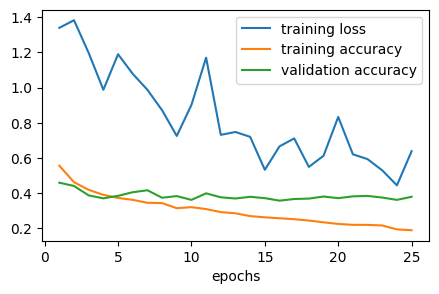

In [58]:
log_resnet = np.load('logs/log_resnet_label_cleaning.npy')
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1),log_resnet[0],label='training loss')
plt.plot(np.arange(1,epochs+1),1-log_resnet[1],label='training accuracy')
plt.plot(np.arange(1,epochs+1),1-log_resnet[2],label='validation accuracy')
plt.legend()
plt.xlabel('epochs')

### 1.4 Clean noisy data

In [59]:
model_resnet = NoisyNet(base_model='resnet50')
model_resnet([X_train[1:2],y_noisy_train[1:2]])
model_resnet.load_weights('models/best_resnet.h5')

In [62]:
test_accuracy=(np.argmax(model_resnet.predict([X_test,y_noisy_test]),axis=-1)==y_clean_test).mean()
print('Test accuracy for label cleaning is: ',test_accuracy)

32/32 [==============================] - 2s 58ms/step
Test accuracy for label cleaning is:  0.637


#### Generating cleaned label using trained network
Loading noisy data...

In [63]:
image_list_classify=[]
noisy_label_list_classify=[]
for file in tqdm(os.listdir(train_classifier)):
#     print("Reading folder {}".format(file))
    filename = os.fsdecode(file)
    filenum = int(filename[:5])
    image_list_classify.append(np.array(Image.open(os.path.join(train_classifier,file))))
    noisy_label_list_classify.append(int(noisy.iloc[filenum-1]))
X_only_noisy=np.array(image_list_classify)
y_only_noisy=np.array(noisy_label_list_classify).reshape(len(noisy_label_list_classify),1)

100%|███████████████████████████████████| 40000/40000 [00:28<00:00, 1387.32it/s]


In [12]:
batch_size = 400
n = len(X_only_noisy) // batch_size
cleaned_labels_resnet = np.array([])
for i in tqdm(range(n)):
    batch = [X_only_noisy[i*batch_size:(i+1)*batch_size],y_only_noisy[i*batch_size:(i+1)*batch_size]]
    cleaned_labels_resnet = np.concatenate((cleaned_labels_resnet,np.argmax(model_resnet(batch),axis=-1)))
cleaned_labels_resnet = cleaned_labels_resnet.astype(int)
np.savetxt("cleaned_labels/cleaned_labels_resnet.csv", cleaned_labels_resnet, delimiter=",")

100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


In [64]:
cleaned_labels_resnet = pd.read_csv('cleaned_labels/cleaned_labels_resnet.csv',header=None).to_numpy().flatten()
cleaned_labels_resnet.size

40000

# 2. Train image classification network using cleaned data

### Using 40000 cleaned noisy data to train the image classifer.

In [68]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X = X_only_noisy
y = cleaned_labels_resnet
x_train, x_val, y_train, y_val=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)
print(len(x_train),len(x_val))

35000 5000


### Build image classification model based on EfficientNetB0(same as model1)

In [69]:
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras import regularizers
base = tensorflow.keras.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_shape=(32,32,3),
                                        pooling='max')
for layer in base.layers[:-4]: layer.trainable =False
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base(inputs)
x = Dense(512,activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5))(x)
x = Dropout(0.2)(x)
outputs = Dense(10,activation='softmax')(x)
model = tensorflow.keras.models.Model(inputs=inputs, outputs=outputs)

In [70]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [45]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_val,y_val),
          batch_size=128,
          callbacks=tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join('models', 'ckpt', 'densenet_prediction.h5'),
                                                       save_best_only = True,save_weights_only=True),
          epochs=10)

Epoch 1/10
235/235 [==============================] - 32s 116ms/step - loss: 1.8432 - accuracy: 0.4574 - val_loss: 1.6712 - val_accuracy: 0.5008
Epoch 2/10
235/235 [==============================] - 27s 115ms/step - loss: 1.5736 - accuracy: 0.5353 - val_loss: 1.6222 - val_accuracy: 0.5152
Epoch 3/10
235/235 [==============================] - 27s 113ms/step - loss: 1.4705 - accuracy: 0.5697 - val_loss: 1.6181 - val_accuracy: 0.5178
Epoch 4/10
235/235 [==============================] - 28s 118ms/step - loss: 1.3865 - accuracy: 0.5953 - val_loss: 1.6369 - val_accuracy: 0.5226
Epoch 5/10
235/235 [==============================] - 28s 120ms/step - loss: 1.3167 - accuracy: 0.6178 - val_loss: 1.6422 - val_accuracy: 0.5350
Epoch 6/10
235/235 [==============================] - 28s 120ms/step - loss: 1.2625 - accuracy: 0.6393 - val_loss: 1.7109 - val_accuracy: 0.5136
Epoch 7/10
235/235 [==============================] - 29s 122ms/step - loss: 1.2083 - accuracy: 0.6623 - val_loss: 1.7275 - val_ac

#### Testing on clean data

In [ ]:
model.load_weights('models/ckpt/densenet_prediction.h5')

In [47]:
pred = np.argmax(model.predict(X_test),axis=-1)

32/32 [==============================] - 3s 35ms/step


In [72]:
print("The accuracy for image classification is: ",(y_clean_test==pred).mean())

The accuracy for image classification is:  0.56
